In [1]:
# Import necessary libraries

# Data manipulation
import pandas as pd
import numpy as np

# Statistical functions
from scipy.stats import zscore

# For concurrency (running functions in parallel)
from concurrent.futures import ThreadPoolExecutor

# For caching (to speed up repeated function calls)
from functools import lru_cache

# For progress tracking
from tqdm import tqdm


# Text Preprocessing and NLP
import nltk

# Stopwords (common words to ignore) from NLTK
from nltk.corpus import stopwords

# Tokenizing sentences/words
from nltk.tokenize import word_tokenize

# Part-of-speech tagging
from nltk import pos_tag

# Lemmatization (converting words to their base form)
from nltk.stem import WordNetLemmatizer


# Model Imports
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
from gensim.models import Word2Vec

2025-02-21 10:13:32.514751: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-21 10:13:32.525387: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740104012.535474 2793004 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740104012.538211 2793004 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-21 10:13:32.549523: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
import os
import sys
from pathlib import Path

if "workding_dir" not in locals():
    workding_dir = str(Path.cwd().parent)
os.chdir(workding_dir)
sys.path.append(workding_dir)
print("working dir:", workding_dir)

working dir: /home/inflaton/code/CrediNews


### Load datasets

In [3]:
from datasets import load_dataset, concatenate_datasets, Dataset

datasets = load_dataset(
    "csv",
    data_files={
        "train": [
            "dataset/train_data_1.csv",
            "dataset/train_data_2.csv",
            "dataset/train_data_3.csv",
            "dataset/train_data_4.csv",
        ],
        "test": "dataset/test_data.csv",
        "rewritten_train": [
            "dataset/rewritten_train_data_1.csv",
            "dataset/rewritten_train_data_2.csv",
            "dataset/rewritten_train_data_3.csv",
            "dataset/rewritten_train_data_4.csv",
        ],
        "rewritten_test": "dataset/rewritten_test_data.csv",
    },
)
datasets

/home/inflaton/miniconda3/envs/fake-news/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['label', 'full_content', 'processed_full_content'],
        num_rows: 54441
    })
    test: Dataset({
        features: ['label', 'full_content', 'processed_full_content'],
        num_rows: 6050
    })
    rewritten_train: Dataset({
        features: ['label', 'full_content', 'processed_full_content'],
        num_rows: 54441
    })
    rewritten_test: Dataset({
        features: ['label', 'full_content', 'processed_full_content'],
        num_rows: 6050
    })
})

### LSTM with Word2Vec (best model)

In [4]:
# Set seeds for reproducibility
import tensorflow as tf
import numpy as np
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


# Train and process Word2Vec embeddings
def train_word2vec_embeddings(
    train_texts, word_index, max_words=10000, embedding_dim=100
):
    """Tokenizes the text, trains Word2Vec, and creates an embedding matrix."""

    # Tokenizing text into word lists
    sentences = [text.split() for text in train_texts]

    # ✅ Train Word2Vec model using processed sentences
    word2vec = Word2Vec(
        sentences=sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4
    )

    # ✅ Ensure consistent vocab size (only include words within max_words limit)
    vocab_size = min(max_words, len(word_index) + 1)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, i in word_index.items():
        if i < vocab_size and word in word2vec.wv:
            embedding_matrix[i] = word2vec.wv[word]

    return embedding_matrix, vocab_size  # ✅ Returns both embedding matrix & vocab size


def create_lstm_model(
    vocab_size,
    embedding_matrix,
    lstm_units=128,
    dropout_rate=0.3,
    learning_rate=0.001,
    l2_lambda=0.01,
):
    """Creates an LSTM model with Dropout and L2 regularization."""

    model = Sequential(
        [
            Embedding(
                vocab_size,
                embedding_matrix.shape[1],
                weights=[embedding_matrix],
                trainable=True,
            ),
            LSTM(units=lstm_units, return_sequences=False, dropout=dropout_rate),
            Dropout(dropout_rate),
            Dense(1, activation="sigmoid", kernel_regularizer=l2(l2_lambda)),
        ]
    )

    # ✅ Use Adam optimizer with a defined learning rate
    model.compile(
        loss="binary_crossentropy", optimizer=Adam(learning_rate), metrics=["accuracy"]
    )

    return model


# ✅ Early stopping callback
early_stopping = EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)

### Define function to train the model

### Define Evaluate model function

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
from tqdm import tqdm


def evaluate_model(model, train_data, val_data):
    print("Evaluating Model")

    max_words = 10000
    max_sequence_length = 300

    train_texts = train_data["processed_full_content"]
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(train_texts)

    y_val = val_data["label"]
    val_texts = val_data["processed_full_content"]

    X_val = pad_sequences(
        tokenizer.texts_to_sequences(val_texts), maxlen=max_sequence_length
    )
    y_pred = (model.predict(X_val) > 0.5).astype(int)

    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1: {f1:.4f}")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
    }

### Set training and validation data

In [6]:
train_data = datasets["train"].to_pandas()
val_data = datasets["test"].to_pandas()
data = pd.concat([train_data, val_data], ignore_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60491 entries, 0 to 60490
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   label                   60491 non-null  int64 
 1   full_content            60491 non-null  object
 2   processed_full_content  60491 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [7]:
# load model
from tensorflow.keras.models import load_model

model = load_model("results/LSTM_model_original.keras")
model.summary()

I0000 00:00:1740104015.980401 2793004 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13512 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ (None, 300, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,352,133 (12.79 MB)

 Trainable params: 1,117,377 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,234,756 (8.52 MB)

In [8]:
%%time

perf_original_model_val_data = evaluate_model(model, train_data, val_data)

Evaluating Model
  4/190 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step   

I0000 00:00:1740104024.524263 2793152 cuda_dnn.cc:529] Loaded cuDNN version 90300


190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Accuracy: 0.9793
Precision: 0.9817
Recall: 0.9709
F1: 0.9763
CPU times: user 9.34 s, sys: 609 ms, total: 9.95 s
Wall time: 9.58 s


In [9]:
val_data_rewritten = datasets["rewritten_test"].to_pandas()
train_data_rewritten = datasets["rewritten_train"].to_pandas()

In [10]:
%%time

perf_original_model_val_data_rewritten = evaluate_model(
    model, train_data, val_data_rewritten
)

Evaluating Model
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Accuracy: 0.8134
Precision: 0.9068
Recall: 0.6392
F1: 0.7498
CPU times: user 8.42 s, sys: 543 ms, total: 8.97 s
Wall time: 8.85 s


In [11]:
train_data_combined = pd.concat([train_data, train_data_rewritten], ignore_index=True)
val_data_combined = pd.concat([val_data, val_data_rewritten], ignore_index=True)

In [12]:
model_combined = load_model("results/LSTM_model_combined.keras")
model_combined.summary()

Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_41 (Embedding)        │ (None, 300, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,352,133 (12.79 MB)

 Trainable params: 1,117,377 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,234,756 (8.52 MB)

In [13]:
perf_combined_model_val_data = evaluate_model(
    model_combined, train_data_combined, val_data
)

Evaluating Model


190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Accuracy: 0.9779
Precision: 0.9761
Recall: 0.9732
F1: 0.9747


In [14]:
perf_combined_model_val_data_rewritten = evaluate_model(
    model_combined, train_data_combined, val_data_rewritten
)

Evaluating Model
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Accuracy: 0.9243
Precision: 0.9147
Recall: 0.9120
F1: 0.9134


In [15]:
data_rewritten = pd.concat(
    [train_data_rewritten, val_data_rewritten], ignore_index=True
)
data_rewritten.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60491 entries, 0 to 60490
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   label                   60491 non-null  int64 
 1   full_content            60491 non-null  object
 2   processed_full_content  60491 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [16]:
model_rewritten = load_model("results/LSTM_model_rewritten.keras")
model_rewritten.summary()

Model: "sequential_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_62 (Embedding)        │ (None, 300, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_62 (LSTM)                  │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,352,133 (12.79 MB)

 Trainable params: 1,117,377 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,234,756 (8.52 MB)

In [17]:
perf_rewritten_model_val_data = evaluate_model(
    model_rewritten, train_data_rewritten, val_data
)

Evaluating Model
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Accuracy: 0.9479
Precision: 0.9779
Recall: 0.9014
F1: 0.9381


In [18]:
perf_rewritten_model_val_data_rewritten = evaluate_model(
    model_rewritten, train_data_rewritten, val_data_rewritten
)

Evaluating Model


190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Accuracy: 0.9187
Precision: 0.9146
Recall: 0.8980
F1: 0.9062


Results saved to results/LSTM_metrics.csv


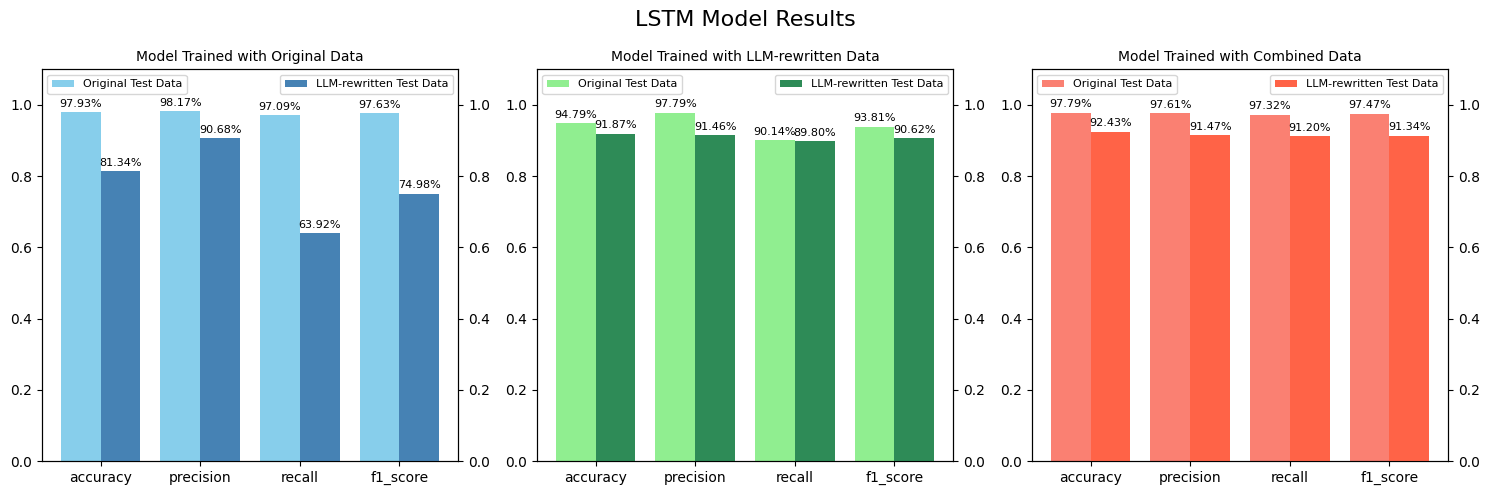

In [19]:
from llm_experiements.utils import *

model = "LSTM"
save_results(
    model,
    perf_original_model_val_data,
    perf_original_model_val_data_rewritten,
    perf_combined_model_val_data,
    perf_combined_model_val_data_rewritten,
    perf_rewritten_model_val_data,
    perf_rewritten_model_val_data_rewritten,
)

plot_results(
    model,
    perf_original_model_val_data,
    perf_original_model_val_data_rewritten,
    perf_combined_model_val_data,
    perf_combined_model_val_data_rewritten,
    perf_rewritten_model_val_data,
    perf_rewritten_model_val_data_rewritten,
)